# Libraries

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
import os

In [4]:
from PIL import Image

In [5]:
import matplotlib.pyplot as plt

In [6]:
from copy import deepcopy

# PATH TO DATA. CHANGE IT

#### UPLOAD THE MAIN ZIP HERE CONTAINING THE FOLDERS TRAINSET AND TESTSET





In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
# Extract the zip locally
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['kaggle_cat_dog.zip']), 'r')
data.extractall()

In [7]:
# Verify that you have a folder testset and trainset here
import os
!ls
os.getcwd()

'kaggle_cat_dog (1).zip'   mnist.pkl	  mnist.zip   sample_data   trainset
 kaggle_cat_dog.zip	   mnist.pkl.gz   models      testset


'/content'

In [8]:
os.listdir(os.path.join('/content', 'trainset'))

['Cat', '.DS_Store', 'Dog']

## Define paths

Path where the kaggle data is stored on PC:

In [7]:
root = r'D:\Scolaire\UdeM\IFT_6135\Assignment1'

In [8]:
data_path = os.path.join(root, 'data')

Path where to save the models:

In [9]:
save_path = os.path.join(root, 'model')

# Getting reproducible results

In [10]:
import random
from keras import backend as K

In [11]:
K.tensorflow_backend._get_available_gpus()

[]

Note that to have deterministic results, you need to apply step 5. However, by doing so, keras can only use 1 core of your computer. As it is a drastic slow down, I chose not to remove this source of randomness as it makes training 3.5 times as slow. If you want to add it, choose $deter = True$ below.

In [12]:
deter = False

In [13]:
def reset_seeds(seed_value=0):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.reset_default_graph()
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session   <--- Too slow so I won't remove randomness from multi processing
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) if deter else None
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

# Data generator (for Keras)

In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [15]:
def fetch_image(ID, which):
    ids = int(ID)
    dir_path = os.path.join(data_path, which + 'set')
    if which=='train':
        if ids > 9999:
            ids = ids - 10000
            clas = 'Dog'
        else:
            clas = 'Cat'
        with Image.open(os.path.join(dir_path, clas, str(ids)+'.'+clas+'.jpg')) as im:
            im_data = np.asarray(im)
    elif which=='test':
        with Image.open(os.path.join(dir_path, 'test', str(ids)+'.jpg')) as im:
            im_data = np.asarray(im)
    else:
        raise AssertionError("Wrong value in fetch image")
        
    s = im_data.shape
    if len(s) == 2:  # ie gray scale
        new_array = np.empty((*s, 3), dtype='int')
        for i in range(s[0]):
            for j in range(s[1]):
                new_array[i,j] = np.repeat(np.array([im_data[i,j]]), 3)
        return new_array
    else:
        return im_data

In [16]:
artificial_data_gen = ImageDataGenerator(
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
im = fetch_image('1', 'train')
artificial_data_gen.fit([im])

In [17]:
class DataGeneratorTrain(keras.utils.Sequence):
    
    def __init__(self, list_IDs, labels, batch_size=32, dim=(64,64), n_channels=3,
                 n_classes=2, shuffle=True, data_aug=None):
        'Initialization'
        if data_aug is not None:
            assert batch_size%data_aug==0, "batch size must be a multiple of the number of generated images"
            self.batch_size = batch_size//data_aug
        else:
            self.batch_size = batch_size
        self.dim = dim
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.data_aug = data_aug
        self.on_epoch_end()
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        if self.data_aug is None:
            # Initialization
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
            y = np.empty((self.batch_size), dtype=int)
            # Generate data
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = fetch_image(ID, 'train')  # Store sample
                y[i] = self.labels[ID]  # Store class
        else:
            # Initialization
            X = np.empty((self.batch_size*self.data_aug, *self.dim, self.n_channels))
            y = np.empty((self.batch_size*self.data_aug), dtype=int)
            # Generate data
            for i, ID in enumerate(list_IDs_temp):
                imag = fetch_image(ID, 'train')  # Store sample
                labl = self.labels[ID]  # Store class
                X[i*self.data_aug,] = imag
                y[i*self.data_aug] = labl
                for j in range(1, self.data_aug):
                    X[i*self.data_aug+j,]=artificial_data_gen.random_transform(imag)
                    y[i*self.data_aug+j] = labl

        if self.n_classes > 2:  
            return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
        else:
            return X, y

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

# Settings

In [18]:
def is_wrong_image(im):
    m=  im.mean()
    return m==255 or m==0

In [19]:
def keep_only_good(list_ID):
    good_list = []
    for ID in list_ID:
        im = fetch_image(str(ID), 'train')
        if not is_wrong_image(im):
            good_list.append(ID)
    return np.array(good_list)

In [20]:
# Parameters
params = {'dim': (64,64),
          'batch_size': 64,
          'n_classes': 1,
          'n_channels': 3,
          'shuffle': True}
val_size = 0.2

# Datasets
total_ids = np.hstack((np.arange(1, 10000), np.arange(10001, 20000)))
total_ids = keep_only_good(total_ids)
number_ids = len(total_ids)
labels = dict()
for ID in total_ids:
    labels[str(ID)] = int(ID>10000)
partition = dict()
np.random.seed(0)
np.random.shuffle(total_ids)
partition['train'] = [str(x) for x in total_ids[:int(number_ids*(1-val_size))]]
partition['validation'] = [str(x) for x in total_ids[int(number_ids*(1-val_size)):]]

# Generators
training_generator = DataGeneratorTrain(deepcopy(partition['train']), labels, **params)
validation_generator = DataGeneratorTrain(deepcopy(partition['validation']), labels, **params)

# Keras architecture

In [21]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D

In [22]:
class CNN1:
    
    def __init__(self, show_summary=True):
        reset_seeds(0)
        self.model = keras.models.Sequential()
        self.history = {'epochs': 0, 'loss': [], 'val_loss': [], 'acc': [], 'val_acc':[]}
        
        # Layer 1
        self.model.add(Conv2D(64, kernel_size=8, strides=2, padding='valid', use_bias=True,
                              activation='relu', input_shape=(64,64,3), data_format='channels_last'))
        self.model.add(MaxPooling2D(3, strides=2, padding='valid', data_format='channels_last'))
        
        # Layer 2
        self.model.add(Conv2D(128, kernel_size=3, strides=1, padding='same', use_bias=True,
                              activation='relu', data_format='channels_last'))
        
        # Layer 3
        self.model.add(Conv2D(256, kernel_size=3, strides=1, padding='same', use_bias=True,
                              activation='relu', data_format='channels_last'))
        
        # Layer 4
        self.model.add(Conv2D(128, kernel_size=3, strides=1, padding='same', use_bias=True,
                              activation='relu', data_format='channels_last'))
        self.model.add(MaxPooling2D(2, padding='valid', data_format='channels_last'))
        
        # Layer 5
        self.model.add(Flatten())
        self.model.add(Dense(128, use_bias=True, activation='relu'))
        
        # Layer 6
        self.model.add(Dense(128, use_bias=True, activation='relu'))
        
        # Layer 7
        self.model.add(Dense(1, use_bias=True, activation='sigmoid'))
        
        sgd = keras.optimizers.SGD(lr=0.0001)
        self.model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
        
        if show_summary:
          self.model.summary()
    
    def train(self, ep, save_path=save_path):
        for _ in range(ep):
            self.model.fit_generator(generator=training_generator,
                                     validation_data=validation_generator, 
                                     epochs=1)
            self.history['epochs'] += 1
            epochs = self.history["epochs"]
            loss, acc = self.model.evaluate_generator(training_generator_no_aug)
            val_loss, val_acc = self.model.evaluate_generator(validation_generator)
            text_status = "Real status --- Epoch: {}".format(epochs)
            for key in ['loss', 'acc', 'val_loss', 'val_acc']:
                self.history[key].append(eval(key))
                text_status += " - {0}: {1}".format(key, round(eval(key), 4))
            print(text_status+'\n')
            
            # save model
            model_json = mod.model.to_json()
            with open(os.path.join(save_path, "model_"+str(epochs)+".json"), "w") as json_file:
                json_file.write(model_json)
            # serialize weights to HDF5
            mod.model.save_weights(os.path.join(save_path, "model_"+str(epochs)+".h5"))

In [24]:
mod = CNN1()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 29, 29, 64)        12352     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flat

In [25]:
# Re-setting the Generators
training_generator = DataGeneratorTrain(deepcopy(partition['train']), labels, data_aug=8, **params)
training_generator_no_aug = DataGeneratorTrain(deepcopy(partition['train']), labels, **params)
validation_generator = DataGeneratorTrain(deepcopy(partition['validation']), labels, **params)
mod = CNN1(False)
mod.train(12)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1999/1999 [==============================] - 188s 94ms/step - loss: 0.6690 - acc: 0.6121 - val_loss: 0.6453 - val_acc: 0.6174
Real status --- Epoch: 1 - loss: 0.6222 - acc: 0.65 - val_loss: 0.6466 - val_acc: 0.6164

Epoch 1/1
1999/1999 [==============================] - 187s 94ms/step - loss: 0.6174 - acc: 0.6615 - val_loss: 0.6013 - val_acc: 0.6681
Real status --- Epoch: 2 - loss: 0.5775 - acc: 0.7005 - val_loss: 0.6009 - val_acc: 0.6678

Epoch 1/1
1999/1999 [==============================] - 187s 94ms/step - loss: 0.5977 - acc: 0.6798 - val_loss: 0.5742 - val_acc: 0.6976
Real status --- Epoch: 3 - loss: 0.5457 - acc: 0.7299 - val_loss: 0.5742 - val_acc: 0.6976

Epoch 1/1
1999/1999 [==============================] - 189s 94ms/step - loss: 0.5785 - acc: 0.6946 - val_loss: 0.6004 - val_acc: 0.6709
Real status --- Epoch: 4 - loss: 0.5646 - acc: 0.6974 - val_loss: 0.5995 - val_acc: 0.6714

Epoch 1/1
1999/1999 [=====================

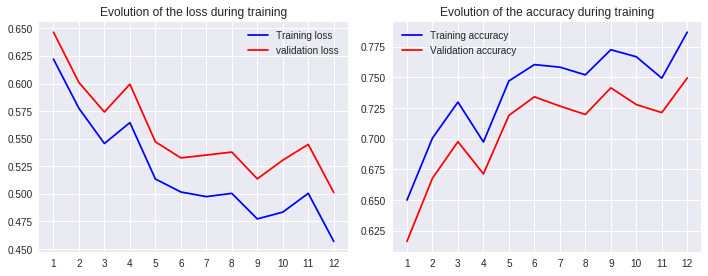

In [26]:
history = mod.history
epochs = history['epochs']

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], color='b', label="Training loss")
plt.plot(history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the loss during training')

plt.subplot(1, 2, 2)
plt.plot(history['acc'], color='b', label="Training accuracy")
plt.plot(history['val_acc'], color='r',label="Validation accuracy")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the accuracy during training')

plt.tight_layout()
plt.show()

In [0]:
sgd = keras.optimizers.SGD(lr=0.0002)  # Lower LR
mod.model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
mod.train(12)

Epoch 1/1
1999/1999 [==============================] - 185s 92ms/step - loss: 0.5272 - acc: 0.7371 - val_loss: 0.5531 - val_acc: 0.7256
Real status --- Epoch: 13 - loss: 0.5013 - acc: 0.758 - val_loss: 0.5543 - val_acc: 0.7251

Epoch 1/1
1999/1999 [==============================] - 185s 93ms/step - loss: 0.5188 - acc: 0.7444 - val_loss: 0.5179 - val_acc: 0.7364
Real status --- Epoch: 14 - loss: 0.4671 - acc: 0.7763 - val_loss: 0.5179 - val_acc: 0.7364

Epoch 1/1
1999/1999 [==============================] - 187s 93ms/step - loss: 0.5095 - acc: 0.7500 - val_loss: 0.4993 - val_acc: 0.7535
Real status --- Epoch: 15 - loss: 0.4566 - acc: 0.7905 - val_loss: 0.4992 - val_acc: 0.7538

Epoch 1/1
1999/1999 [==============================] - 186s 93ms/step - loss: 0.5030 - acc: 0.7550 - val_loss: 0.5225 - val_acc: 0.7399
Real status --- Epoch: 16 - loss: 0.4686 - acc: 0.7713 - val_loss: 0.5225 - val_acc: 0.7399

Epoch 1/1
1999/1999 [==============================] - 188s 94ms/step - loss: 0.4974 

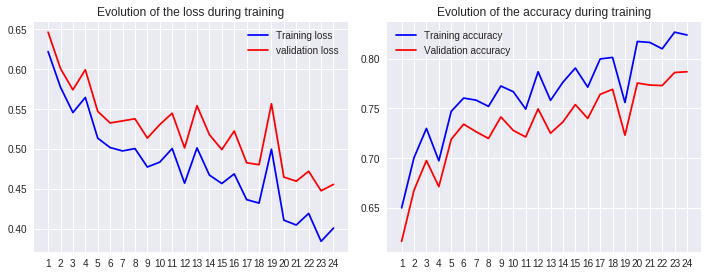

In [29]:
history = mod.history
epochs = history['epochs']

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], color='b', label="Training loss")
plt.plot(history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the loss during training')

plt.subplot(1, 2, 2)
plt.plot(history['acc'], color='b', label="Training accuracy")
plt.plot(history['val_acc'], color='r',label="Validation accuracy")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the accuracy during training')

plt.tight_layout()
plt.show()

In [0]:
sgd = keras.optimizers.SGD(lr=0.0001)  # Lower LR
mod.model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
mod.train(9)

Epoch 1/1
1999/1999 [==============================] - 189s 95ms/step - loss: 0.4404 - acc: 0.7946 - val_loss: 0.4507 - val_acc: 0.7941
Real status --- Epoch: 25 - loss: 0.3779 - acc: 0.8309 - val_loss: 0.4507 - val_acc: 0.7941

Epoch 1/1
1999/1999 [==============================] - 189s 95ms/step - loss: 0.4399 - acc: 0.7944 - val_loss: 0.4336 - val_acc: 0.7986
Real status --- Epoch: 26 - loss: 0.3706 - acc: 0.8352 - val_loss: 0.4336 - val_acc: 0.7986

Epoch 1/1
1999/1999 [==============================] - 184s 92ms/step - loss: 0.4354 - acc: 0.7971 - val_loss: 0.4392 - val_acc: 0.7923
Real status --- Epoch: 27 - loss: 0.3678 - acc: 0.8363 - val_loss: 0.4392 - val_acc: 0.7923

Epoch 1/1
1999/1999 [==============================] - 183s 92ms/step - loss: 0.4322 - acc: 0.7986 - val_loss: 0.4293 - val_acc: 0.8014
Real status --- Epoch: 28 - loss: 0.3636 - acc: 0.8397 - val_loss: 0.4293 - val_acc: 0.8014

Epoch 1/1
1999/1999 [==============================] - 185s 92ms/step - loss: 0.4304

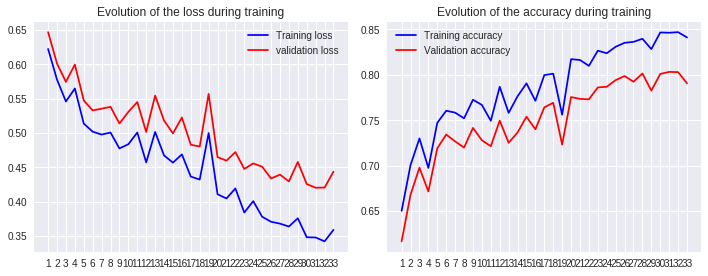

In [32]:
history = mod.history
epochs = history['epochs']

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], color='b', label="Training loss")
plt.plot(history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the loss during training')

plt.subplot(1, 2, 2)
plt.plot(history['acc'], color='b', label="Training accuracy")
plt.plot(history['val_acc'], color='r',label="Validation accuracy")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the accuracy during training')

plt.tight_layout()
plt.show()

In [0]:
sgd = keras.optimizers.SGD(lr=0.00005)  # Lower LR
mod.model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
mod.train(8)

Epoch 1/1
1999/1999 [==============================] - 185s 93ms/step - loss: 0.4104 - acc: 0.8111 - val_loss: 0.4133 - val_acc: 0.8095
Real status --- Epoch: 34 - loss: 0.3333 - acc: 0.8542 - val_loss: 0.4133 - val_acc: 0.8095

Epoch 1/1
1999/1999 [==============================] - 184s 92ms/step - loss: 0.4092 - acc: 0.8121 - val_loss: 0.4122 - val_acc: 0.8117
Real status --- Epoch: 35 - loss: 0.3282 - acc: 0.8552 - val_loss: 0.4122 - val_acc: 0.8117

Epoch 1/1
1999/1999 [==============================] - 183s 92ms/step - loss: 0.4071 - acc: 0.8131 - val_loss: 0.4165 - val_acc: 0.8105
Real status --- Epoch: 36 - loss: 0.3311 - acc: 0.8557 - val_loss: 0.4177 - val_acc: 0.8097

Epoch 1/1
1999/1999 [==============================] - 182s 91ms/step - loss: 0.4067 - acc: 0.8130 - val_loss: 0.4231 - val_acc: 0.8049
Real status --- Epoch: 37 - loss: 0.3344 - acc: 0.8522 - val_loss: 0.4231 - val_acc: 0.8049

Epoch 1/1
1999/1999 [==============================] - 183s 92ms/step - loss: 0.4026

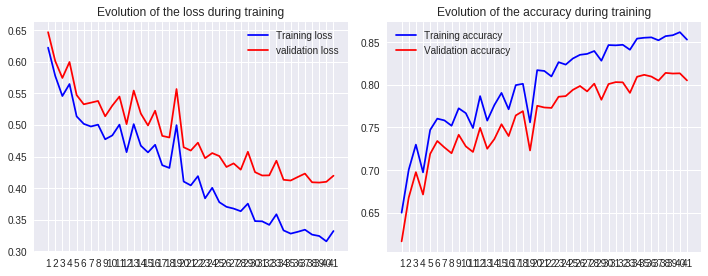

In [35]:
history = mod.history
epochs = history['epochs']

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], color='b', label="Training loss")
plt.plot(history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the loss during training')

plt.subplot(1, 2, 2)
plt.plot(history['acc'], color='b', label="Training accuracy")
plt.plot(history['val_acc'], color='r',label="Validation accuracy")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the accuracy during training')

plt.tight_layout()
plt.show()

In [0]:
sgd = keras.optimizers.SGD(lr=0.00003)  # Lower LR
mod.model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
mod.train(8)

Epoch 1/1
1999/1999 [==============================] - 185s 93ms/step - loss: 0.3955 - acc: 0.8196 - val_loss: 0.4057 - val_acc: 0.8180
Real status --- Epoch: 42 - loss: 0.3158 - acc: 0.8633 - val_loss: 0.4057 - val_acc: 0.818

Epoch 1/1
1999/1999 [==============================] - 184s 92ms/step - loss: 0.3936 - acc: 0.8207 - val_loss: 0.4078 - val_acc: 0.8120
Real status --- Epoch: 43 - loss: 0.3114 - acc: 0.8638 - val_loss: 0.4078 - val_acc: 0.812

Epoch 1/1
1999/1999 [==============================] - 184s 92ms/step - loss: 0.3931 - acc: 0.8201 - val_loss: 0.4028 - val_acc: 0.8208
Real status --- Epoch: 44 - loss: 0.3112 - acc: 0.8667 - val_loss: 0.4028 - val_acc: 0.8208

Epoch 1/1
1999/1999 [==============================] - 185s 92ms/step - loss: 0.3918 - acc: 0.8214 - val_loss: 0.4159 - val_acc: 0.8122
Real status --- Epoch: 45 - loss: 0.3205 - acc: 0.8599 - val_loss: 0.4159 - val_acc: 0.8122

Epoch 1/1
1999/1999 [==============================] - 185s 92ms/step - loss: 0.3897 -

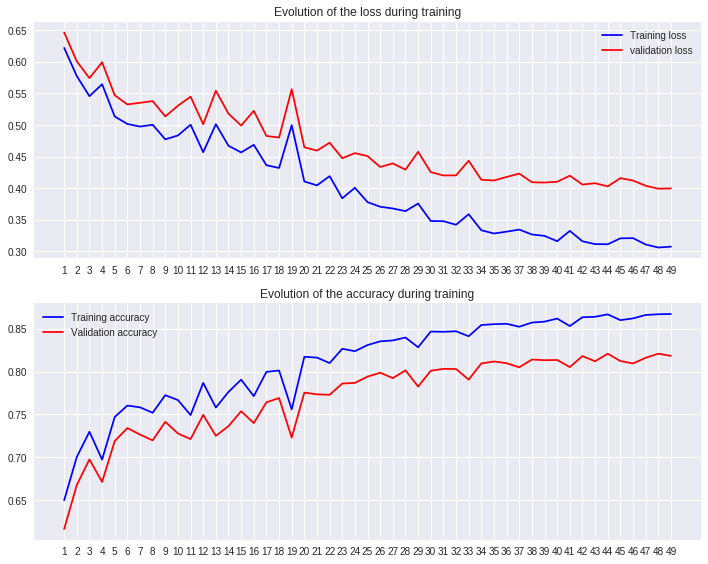

In [38]:
history = mod.history
epochs = history['epochs']

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(history['loss'], color='b', label="Training loss")
plt.plot(history['val_loss'], color='r', label="validation loss")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the loss during training')

plt.subplot(2, 1, 2)
plt.plot(history['acc'], color='b', label="Training accuracy")
plt.plot(history['val_acc'], color='r',label="Validation accuracy")
plt.xticks(np.arange(0, epochs, 1), [str(x) for x in np.arange(1, epochs+1, 1)])
plt.legend(loc='best', shadow=True)
plt.title('Evolution of the accuracy during training')

plt.tight_layout()
plt.show()

### Predicting

In [39]:
epochs

49

We choose one epoch that yielded good results. The 48th for instance:

In [0]:
epochs_to_load = 48

In [49]:
mod = CNN1(False)
json_file = open(os.path.join(save_path, "model_"+str(epochs_to_load)+".json"), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join(save_path, "model_"+str(epochs_to_load)+".h5"))
print("Loaded model from disk")

Loaded model from disk


In [0]:
sgd = keras.optimizers.SGD(lr=0.00003)  # Any learning rate works as we won't try to optimize anymore
loaded_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
mod.model = loaded_model

In [51]:
# Datasets
x_test = list()
for i in range(1, 5000):
    x_test.append(fetch_image(str(i), 'test'))
x_test = np.array(x_test)
print(x_test.shape)

(4999, 64, 64, 3)


In [0]:
# Prediction
y_pred = mod.model.predict(x_test)
y_pred_classes = ['Cat' if x<0.5 else 'Dog' for x in y_pred]

In [0]:
def create_submission_file(classes, dir_path, file_name):
    with open(os.path.join(dir_path, file_name+'.csv'), 'w') as f:
        f.write('id,label\n')
        for i, cl in enumerate(classes):
            f.write(str(i+1)+','+cl)
            f.write('\n')
    print('Submission file created!')

In [54]:
create_submission_file(y_pred_classes, save_path, 'medium_model_2')

Submission file created!


Downloading model and csv file:

In [0]:
files.download(os.path.join(save_path, 'medium_model_2.csv'))

In [0]:
files.download(os.path.join(save_path, "model_"+str(epochs_to_load)+".json"))

In [0]:
files.download(os.path.join(save_path, "model_"+str(epochs_to_load)+".h5"))

### Analysing feature maps

In [23]:
epochs_to_load = 48

In [24]:
mod = CNN1(False)
json_file = open(os.path.join(save_path, "model_"+str(epochs_to_load)+".json"), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join(save_path, "model_"+str(epochs_to_load)+".h5"))
print("Loaded model from disk")

Loaded model from disk


In [25]:
sgd = keras.optimizers.SGD(lr=0.00003)  # Any learning rate works as we won't try to optimize anymore
loaded_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
mod.model = loaded_model

In [26]:
layer_outputs = [layer.output for layer in mod.model.layers[:6]] # Extracts the outputs of the top 6 layers (only convolutional and max pool)
activation_model = keras.models.Model(inputs=mod.model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [27]:
activations = activation_model.predict(fetch_image('1', 'test').reshape(1, 64, 64, 3)) #  We want the output of the layers for a given image (here it's a cat)

Cat image that we will show though filters:

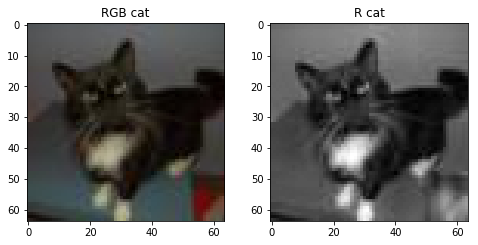

In [39]:
im = fetch_image('1', 'test')

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(im)
plt.title('RGB cat')

for i, c in enumerate(['R', 'G', 'B'][:1]):
    plt.subplot(2, 2, 2+i)
    plt.imshow(im.transpose()[i].transpose(), cmap=plt.cm.gray)
    plt.title(c+' cat')
plt.show()

We will only output the output of the layers for 1 input channel as it would be too big otherwise:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


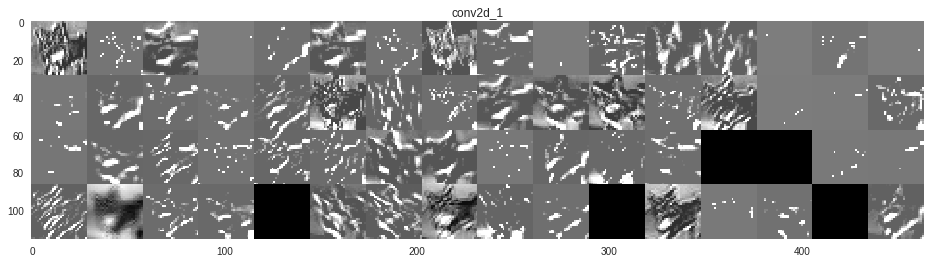

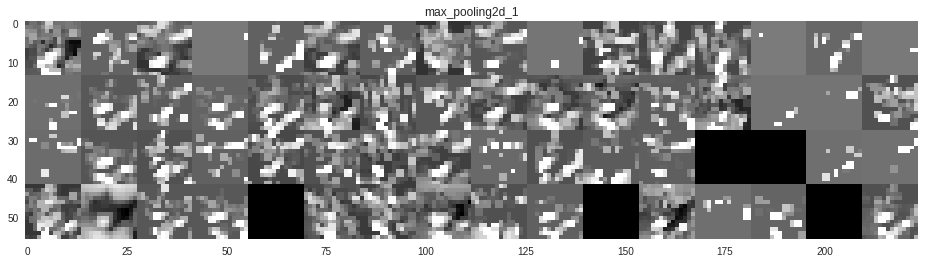

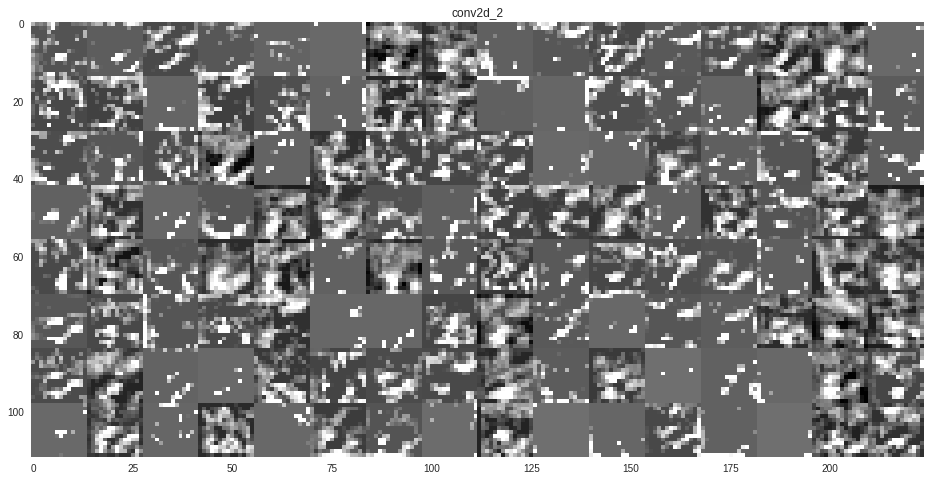

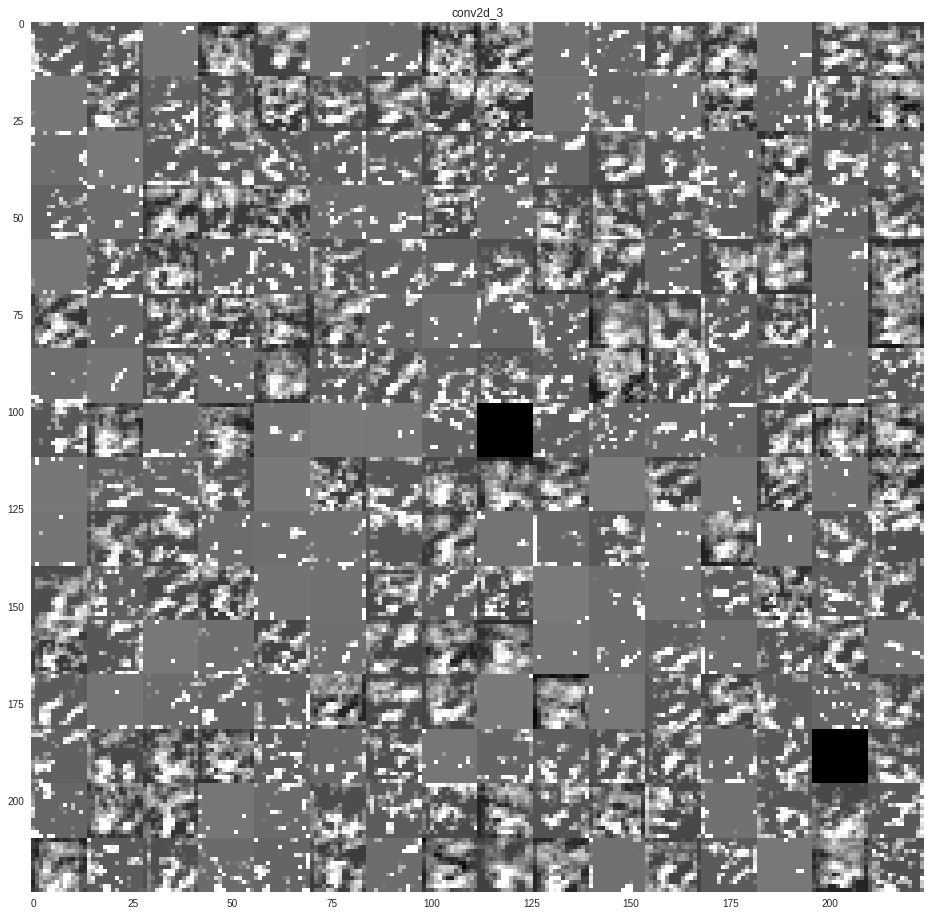

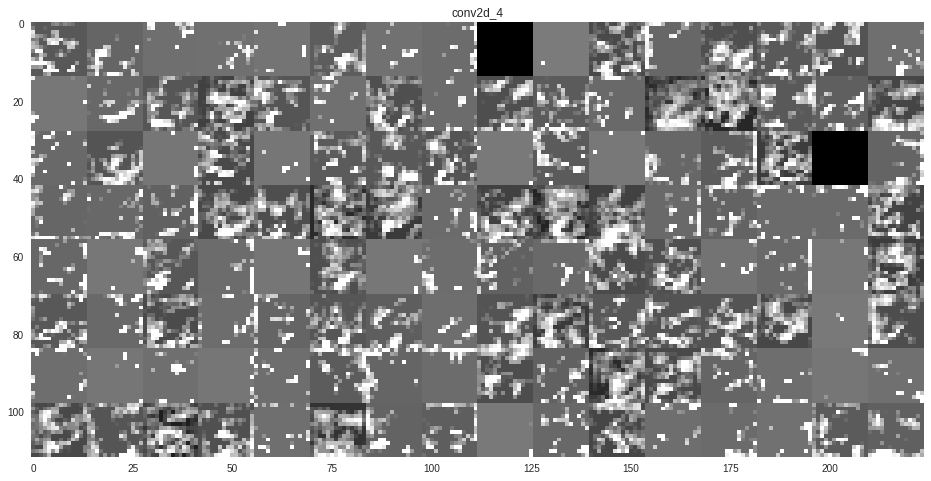

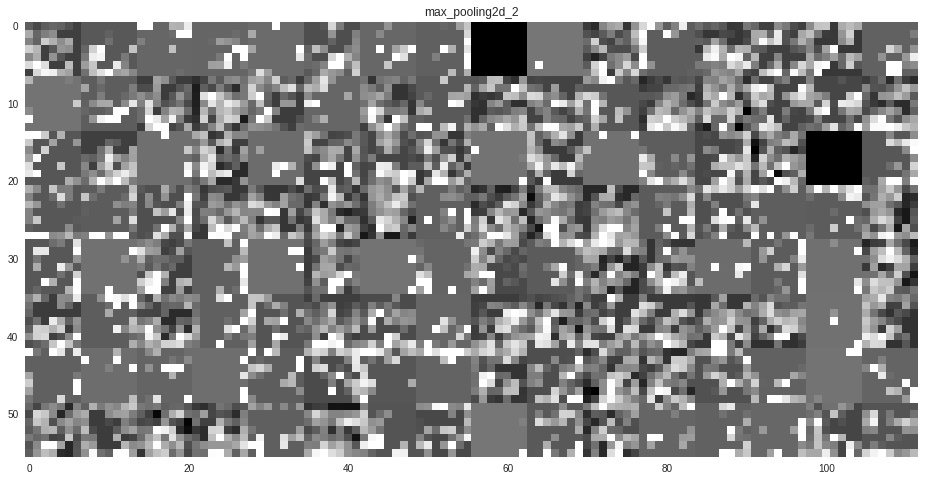

In [71]:
layer_names = []
for layer in mod.model.layers[:6]:
    layer_names.append(layer.name) #  Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): #  Displays the feature maps
    n_features = layer_activation.shape[-1] #  Number of features in the feature map
    size = layer_activation.shape[1] #  The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row #  Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): #  Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() #  Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, #  Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap=plt.cm.gray)

Trying with the image of a dog instead:

In [0]:
activations = activation_model.predict(fetch_image('4', 'test').reshape(1, 64, 64, 3)) #  We want the output of the layers for a given image (here it's a dog)

Dog image that we will show though filters:

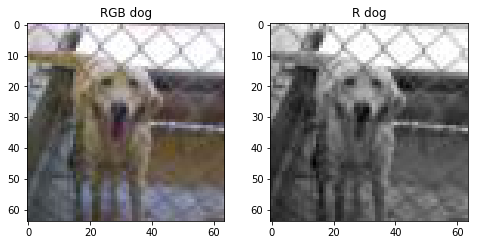

In [38]:
im = fetch_image('4', 'test')

plt.figure(figsize=(8, 8))

plt.subplot(2, 2, 1)
plt.imshow(im)
plt.title('RGB dog')

for i, c in enumerate(['R', 'G', 'B'][:1]):
    plt.subplot(2, 2, 2+i)
    plt.imshow(im.transpose()[i].transpose(), cmap=plt.cm.gray)
    plt.title(c+' dog')
plt.show()

We will only output the output of the layers for 1 input channel as it would be too big otherwise:

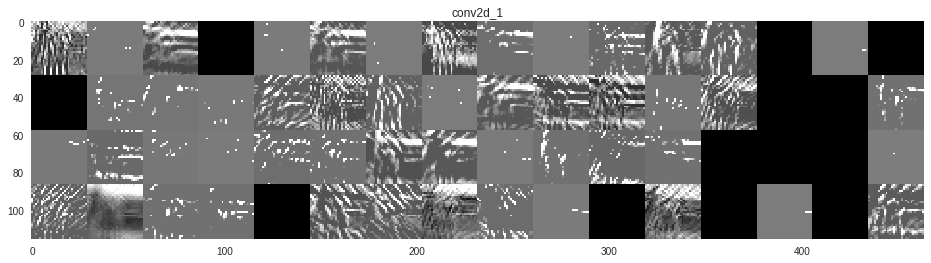

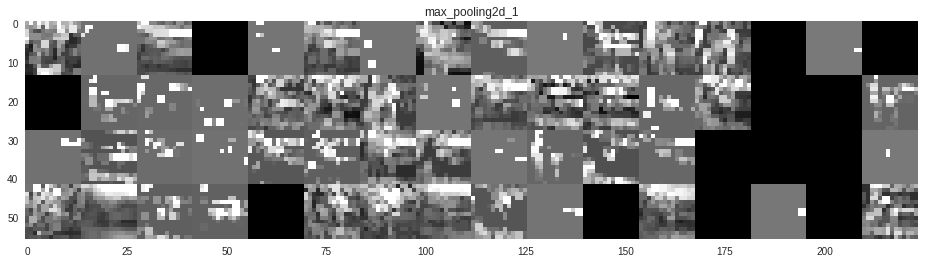

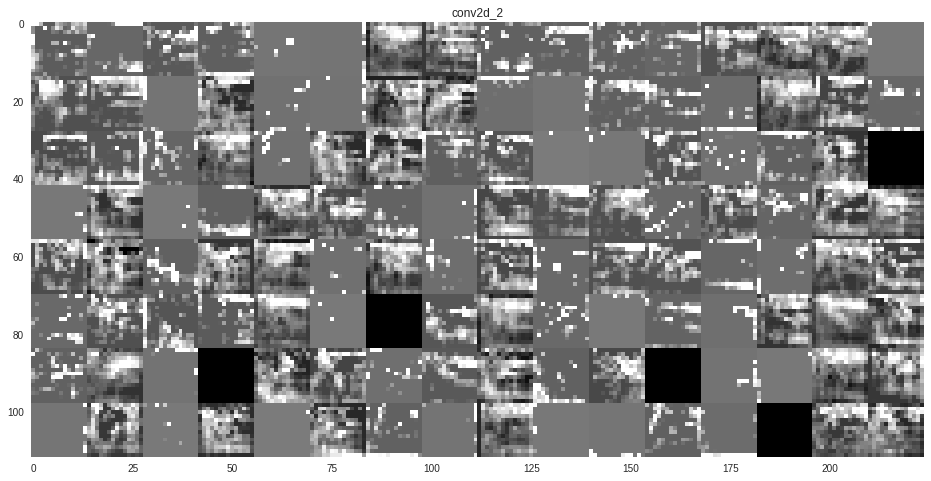

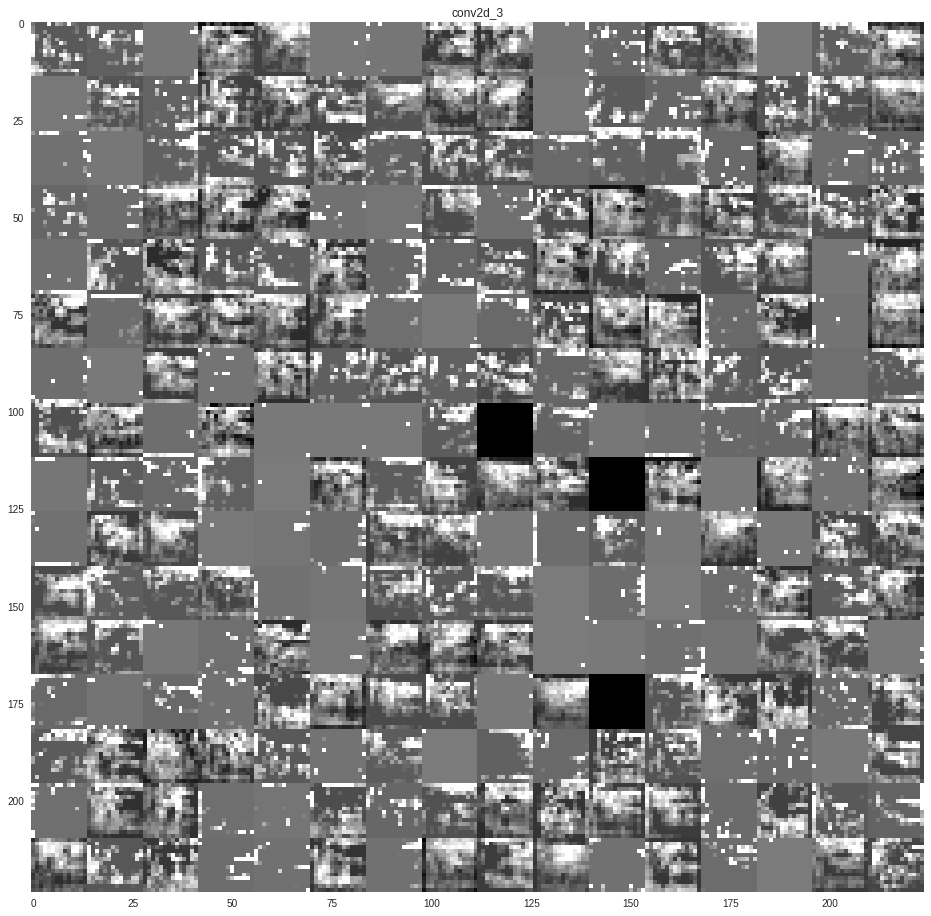

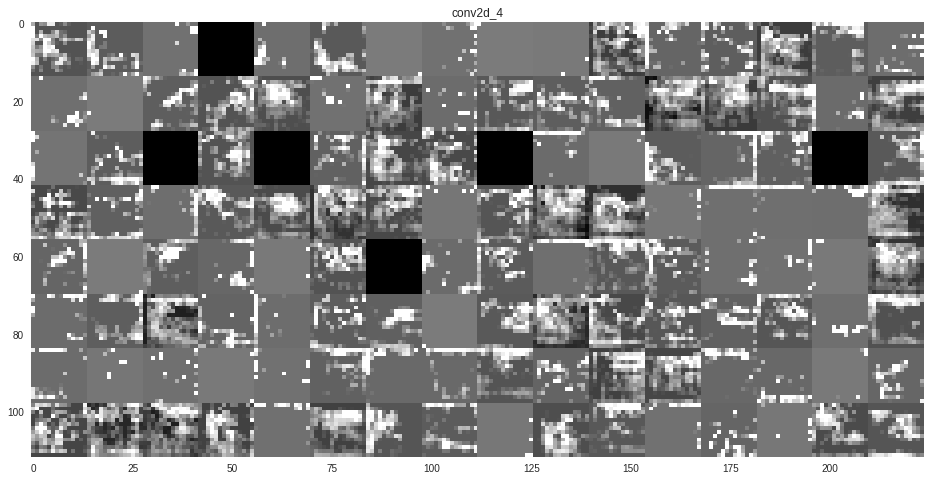

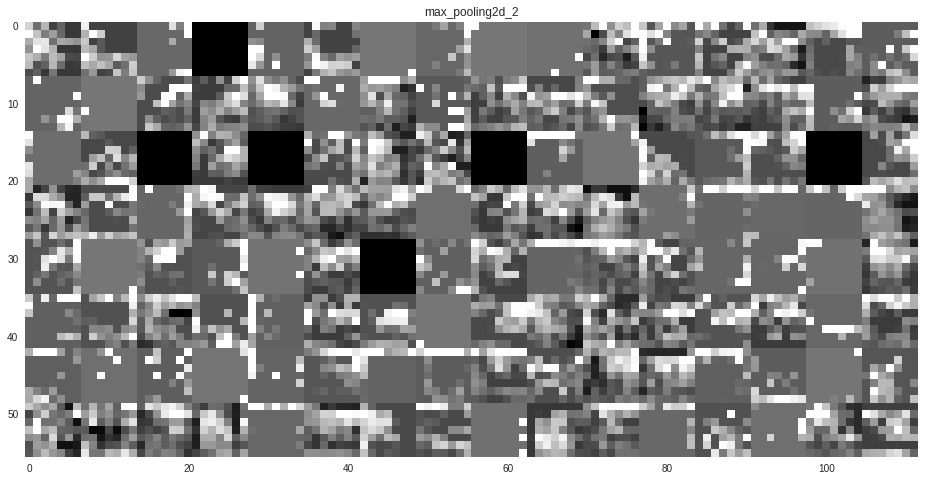

In [67]:
layer_names = []
for layer in mod.model.layers[:6]:
    layer_names.append(layer.name) #  Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): #  Displays the feature maps
    n_features = layer_activation.shape[-1] #  Number of features in the feature map
    size = layer_activation.shape[1] #  The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row #  Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): #  Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() #  Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, #  Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap=plt.cm.gray)

### Misclassified images

ID: 225
Score 0.567
Real class: 1


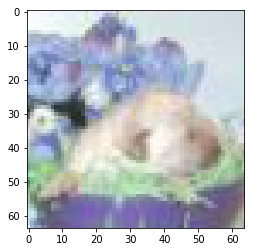

ID: 5959
Score 0.087
Real class: 1


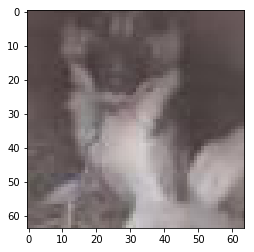

ID: 6876
Score 0.718
Real class: 0


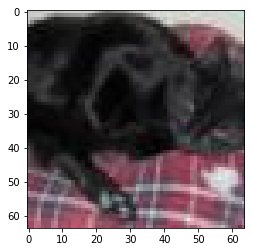

ID: 4833
Score 0.766
Real class: 0


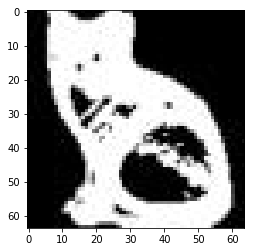

ID: 3605
Score 0.923
Real class: 0


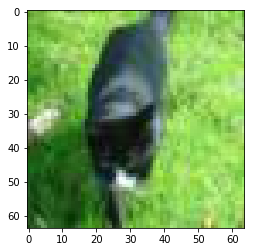

In [64]:
for ID in ['10225', '15959', '6876', '4833', '3605']:
    im = fetch_image(ID, 'train')
    valu = int(ID)-10000 if int(ID)>10000 else int(ID)
    print("ID:", valu)
    print("Score", round(mod.model.predict(im.reshape(1,64,64,3))[0][0], 3))
    print("Real class:", labels[ID])
    plt.imshow(im)
    plt.show()